In [1]:
#Importing of Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaModel
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,Dense,Bidirectional,Conv2D,MaxPooling2D,Flatten,concatenate,GlobalAveragePooling2D,BatchNormalization,Lambda,Add,Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from transformers import AutoTokenizer, TFAutoModel, TFBertModel, logging
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
bert = TFRobertaModel.from_pretrained('roberta-base')


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [2]:
#Import Datset
dat = pd.read_csv('C:\\Users\\UWAMAHIRWE\\Desktop\\Thesis\\crypto_data\\fin_data.csv')

In [3]:
#Preparation Of Data Pipelines
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset


class preparation():
    def __init__(self,df,tokenizer,bert,max_len_tweet,max_len_text_data,tweet=True,tweet_text=True,image=True):
        self.df=df
        self.tokenizer = tokenizer
        self.bert = bert
        self.max_len_tweet=max_len_tweet
        self.max_len_text_data=max_len_text_data
        self.tweet=tweet
        self.tweet_text=tweet_text
        self.image=image
        self.tokenizer=tokenizer
        self.bert=bert
        
        
    #TOKENIZATION OF TEXT     
    def tokenize(self,sentences,max_len):
        
        input_ids=[]
        attention_masks=[]
        for sent in sentences:
            bert_inp=self.tokenizer.encode_plus(sent,max_length=max_len,add_special_tokens = True,pad_to_max_length = True,return_attention_mask = True,truncation = True)
            input_ids.append(bert_inp['input_ids'])
            attention_masks.append(bert_inp['attention_mask'])

        input_ids=np.asarray(input_ids)
        attention_masks=np.array(attention_masks)
        return input_ids,attention_masks
    
    
    def prep_txt(self,input_ids, masks, input_ids2, masks2, path, labels):
        image = tf.io.read_file(path)
        image = tf.io.decode_image(image, channels=3,expand_animations = False)
        image = tf.cast(image, tf.float32) / 255.0 
        image = tf.image.resize(image, size=(200, 200)) 
        return {'input_ids': input_ids, 'attention_mask': masks, 
            'input_ids2': input_ids2, 'attention_mask2': masks2,'images': image}, labels


    def prep_image(self,path, labels):
        image = tf.io.read_file(path)
        image = tf.io.decode_image(image, channels=3,expand_animations = False)
        image = tf.cast(image, tf.float32) / 255.0 
        image = tf.image.resize(image, size=(200, 200)) 
        return {'images1': image}, labels

    def prep_tweet(self,input_ids, masks, labels):
        return {'input_ids': input_ids, 'attention_mask': masks}, labels
    
    def prep_txt_imtxt_image(self,input_ids, masks, input_ids2, masks2,labels):
        return {'input_ids': input_ids, 'attention_mask': masks, 
            'input_ids2': input_ids2, 'attention_mask2': masks2}, labels

    
    
    
    def prep_data_pipeline(self):
        sentences=self.df['tweet']
        sentences1=self.df['text_data']
        input_ids,attention_masks=self.tokenize(sentences,self.max_len_tweet)
        input_ids1,attention_masks1=self.tokenize(sentences1,self.max_len_text_data)
        paths =[img for i,img in enumerate(self.df['Path'])]
        labels=self.df['Target'].to_numpy()#.reshape((-1,1))
        if self.tweet:
            if self.tweet_text:
                if self.image:
                    dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks, input_ids1, attention_masks1,paths,labels)).map(self.prep_txt).batch(5)
                    
                else:
                    dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks, input_ids1, attention_masks1,labels)).map(self.prep_txt_imtxt_image).batch(5)
                   
            
            elif self.tweet_text==False:
                if self.image==False:
                    dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks,labels)).map(self.prep_tweet).batch(5)
                    
                
                
        elif self.tweet==False:
            if self.tweet_text==False:
                if self.image:
                    dataset=tf.data.Dataset.from_tensor_slices((paths,labels)).map(self.prep_image).batch(5)
                    
                    
        return dataset    
        



In [4]:
train_1,test_1=train_test_split(dat, test_size=.25, random_state=42)
train=preparation(df=train_1,tokenizer=tokenizer,bert=bert,max_len_tweet=250,max_len_text_data=245,tweet=True,tweet_text=True,image=False).prep_data_pipeline()
test=preparation(df=test_1,tokenizer=tokenizer,bert=bert,max_len_tweet=250,max_len_text_data=245,tweet=True,tweet_text=True,image=False).prep_data_pipeline()

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [5]:
class MLPBlock(keras.layers.Layer):
    def __init__(self):
        super(MLPBlock, self).__init__()
        self.BatchNormalization = tf.keras.layers.BatchNormalization()
        self.Dense1 = tf.keras.layers.Dense(115, activation='relu', kernel_regularizer=l2(0.01))
        self.Dropout = tf.keras.layers.Dropout(0.2)
        self.Dense2 = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')
    
    def call(self, inputs):
        x = self.BatchNormalization(inputs)
        x = self.Dense1(x)
        x = self.Dropout(x)
        x = self.Dense2(x)
        
        return x

In [6]:
class Rob(keras.Model):
    def __init__(self):
        super(Rob, self).__init__()
        self.GlobalMaxPool1D = tf.keras.layers.GlobalMaxPool1D()
        self.bert=  TFRobertaModel.from_pretrained('roberta-base')
        #self.Flat=tf.keras.layers.Flatten()
        self.block = MLPBlock()
        self.bert.trainable=False
        
    def call(self, inputs):
    
        input_ids_c = tf.keras.layers.concatenate([inputs[0],inputs[2]])
        mask_c =  tf.keras.layers.concatenate([inputs[1],inputs[3]])
        text_embeddings = bert(input_ids_c, attention_mask=mask_c)[0]  #We take the first value from tuple which is the pooled_output which is the embedding hence [0]
        #x = self.Flat(x) Can use GlobalMaxPool1D or Flatten but when used Flatten caused overfitting issues
        x = self.GlobalMaxPool1D(text_embeddings)
        x = self.block(x)
        return x

In [7]:
def run_model(tweet,img,tweet_text,tweet_txt_img):
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
    loss = tf.keras.losses.BinaryCrossentropy()
    checkpoint_filepath = r'C:\\Users\\UWAMAHIRWE\\Desktop\\Thesis\\crypto_data\\model_wt_tweet_text_robert.ckpt'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
    early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=1)
    seq_len=250
    seq_len2=245
    if img:
        ins = tf.keras.layers.Input(shape=(200, 200, 3),name='images1')
        outs = Images()(ins)
        model = tf.keras.Model(ins, outs)
        model.summary()
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        history=model.fit(train,validation_data=test, epochs=10,callbacks=[model_checkpoint_callback,early_stop])
    elif tweet_txt_img:
        input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
        mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
        input_ids2 = tf.keras.layers.Input(shape=(seq_len2,), name='input_ids2', dtype='int32')
        mask2 = tf.keras.layers.Input(shape=(seq_len2,), name='attention_mask2', dtype='int32')
        image_inputs=tf.keras.layers.Input(shape=(200,200,3),name="images")
        ins=[input_ids, mask,input_ids2, mask2,image_inputs]
        outs = Rob()(ins)
        model = tf.keras.Model(ins, outs)
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        model.summary()    
        history=model.fit(train,validation_data=test, epochs=10,callbacks=[model_checkpoint_callback,early_stop])
    elif tweet_text:
        input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
        mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
        input_ids2 = tf.keras.layers.Input(shape=(seq_len2,), name='input_ids2', dtype='int32')
        mask2 = tf.keras.layers.Input(shape=(seq_len2,), name='attention_mask2', dtype='int32')
        ins=[input_ids, mask,input_ids2, mask2]
        outs = Rob()(ins)
        model = tf.keras.Model(ins, outs)
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        model.summary()
        history=model.fit(train,validation_data=test, epochs=10,callbacks=[model_checkpoint_callback,early_stop])
        
    elif tweet:
        input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
        mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
        ins=[input_ids, mask]
        outs = Rob()(ins)
        model = tf.keras.Model(ins, outs)
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        model.summary()
        history=model.fit(train,validation_data=test, epochs=10,callbacks=[model_checkpoint_callback,early_stop])
    
    return history,model



In [8]:
model=run_model(tweet=False,img=False,tweet_text=True,tweet_txt_img=False)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 250)]

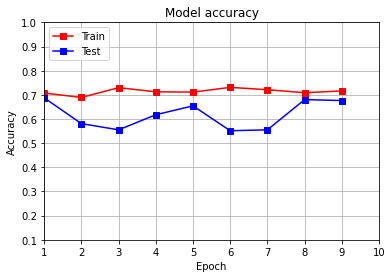

In [9]:
x=plt.plot(model[0].history['accuracy'],linestyle='-', marker='s', color='r')
y=plt.plot(model[0].history['val_accuracy'],linestyle='-', marker='s', color='b')
def plot(train,test):
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.xlim(1, 10)
    plt.ylim(0.1,1 )
    plt.grid()
    return plt.show()
plot(x,y)       

In [10]:
z=model[1].predict(test)
ypred=np.where(z<=0.49,0,1)
ytest=[k for i,j in test for k in j.numpy()]


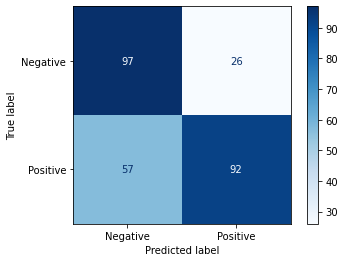

In [11]:
def confusion_mat(ytest,ypred):
    cm = confusion_matrix(ytest, ypred)
    labels = ["Negative","Positive"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(cmap=plt.cm.Blues,values_format='d')
    return plt.show()

confusion_mat(ytest,ypred)

In [12]:
print("Precision: {}".format(precision_score(ytest, ypred)))
print('Recall: %.3f' % recall_score(ytest, ypred))
print('Accuracy: %.3f' % accuracy_score(ytest, ypred))
print('F1 Score: %.3f' % f1_score(ytest, ypred))


Precision: 0.7796610169491526
Recall: 0.617
Accuracy: 0.695
F1 Score: 0.689


In [13]:
target_names = ["Negative","Positive"]
print(classification_report(ytest, ypred, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.63      0.79      0.70       123
    Positive       0.78      0.62      0.69       149

    accuracy                           0.69       272
   macro avg       0.70      0.70      0.69       272
weighted avg       0.71      0.69      0.69       272



In [14]:
ypred=ypred.flatten()
test_1['Pred Target']=ypred

C:\Users\UWAMAHIRWE\AppData\Local\Temp\ipykernel_15088\758176997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_1['Pred Target']=ypred


In [15]:
test_1.to_csv("Predicted+Tweet+Text+Robert.csv")